In [1]:
import prepare
import numpy as np
import stresnet
import torch
import h5py

In [6]:
print(torch.cuda.is_available())

False


In [7]:
a=np([[1,0],[2,0]])

TypeError: 'module' object is not callable

In [8]:
c,p,t,y,d=prepare.get_all_data()

4800 4800
(6, 32, 32)
3792 3792 3792 3792 4800
4368 4368
(6, 32, 32)
3360 3360 3360 3360 4368
5472 5472
(6, 32, 32)
4464 4464 4464 4464 5472


In [5]:
c.dtype

dtype('float64')

In [6]:
y_max=y.max()
y_min=y.min()
print(y_max,y_min)

1270.0 0.0


In [9]:
f=prepare.get_feature_data(d)
print(len(f))

Temperature (59006,) float64
Weather (59006, 17) float64
WindSpeed (59006,) float64
date (59006,) |S10
11616


In [13]:
def minmax(data):
    data=1.*(data-0)/(1270-0)
    data=data*2.0-1.0
    return data
def rescale(data,max=1270.0,min=0.0):
    data=(data+1.)/2.
    data=1.*data*(max-min)+min
    return data

In [10]:
from torch.utils import data
class TaxiBJ(data.Dataset):
    def __init__(self):
        pass
    def __getitem__(self,index):
        return minmax(c[index]),minmax(p[index]),minmax(t[index]),f[index],minmax(y[index])
    
    def __len__(self):
        return len(c)

In [11]:
dataset=TaxiBJ()

In [ ]:
loader=data.DataLoader(dataset=dataset,batch_size=1000,shuffle = false)

In [18]:
ct,pt,tt,ft,yt=dataset[1]
ct,pt,tt,ft,yt=trans(ct,pt,tt,ft,yt)

In [2]:
device=torch.device('cpu')

In [16]:
class ToTensor(object):
    def __call__(self,c,p,t,f,y):
        ct=torch.from_numpy(c).unsqueeze(0)
        pt=torch.from_numpy(p).unsqueeze(0)
        tt=torch.from_numpy(t).unsqueeze(0)
        ft=torch.from_numpy(f).unsqueeze(0)
        yt=torch.from_numpy(y).unsqueeze(0)
        return ct.to(device),pt.to(device),tt.to(device),ft.to(device),yt.to(device)

In [17]:
trans=ToTensor()

In [3]:
net=stresnet.ResNet()
net.double()

ResNet(
  (close): resunit(
    (unit): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (2): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (3): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (4): ReLU(inplace)
      (5): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (period): resunit(
    (unit): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): residual(
        (left): 

In [20]:
from tensorboardX import SummaryWriter
with SummaryWriter(comment='ST-ResNet')as w:
    w.add_graph(net, (ct,pt,tt,ft))

In [15]:
import torch.optim as optim
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [16]:
crit=torch.nn.MSELoss()

In [14]:
ff=open('train_6_14.txt','w')


In [17]:
for i in range(15500):
    for step in enumerate(loader):
        ct,pt,tt,ft,yt=dataset[i]
        ct,pt,tt,ft,yt=trans(ct,pt,tt,ft,yt)
        optimizer.zero_grad()
        out=net(ct,pt,tt,ft)
        loss=crit(out,yt)
        loss.backward()
        optimizer.step()
        #ff.write(str(loss.item())+'\n')
        print(loss.item())
ff.close()

3.1490908669437756
3.0617460089436364
2.8599509527624885
2.587553154949387
2.2677584886530617
1.806969123269349
1.549809777817869
1.3293118069220549
1.177391913426147
1.136411436817614
1.099444796736321
1.050706345004285
0.9997253154284312
0.943094006251555
0.8889380768739189
0.8562591942034591
0.8378652851296542
0.822607402408633
0.804086218042037
0.8002835873229358
0.7879130792355621
0.7773824156617457
0.7769951828421154
0.7882816218241336
0.7958927076756707
0.8006709358681616
0.7954954630376255
0.7924277309386748
0.7979155512104669
0.7915680236919559
0.7865007700459967
0.7873824329963316
0.782270799665556
0.7843416664275273
0.7963795169227645
0.8091263362497771
0.8141810980392645
0.8147867155259619
0.7995546794129467
0.815028326142685
0.8328999181354251
0.8389233528075309
0.8479404051442109
0.8603783445855608
0.8738799133651713
0.8638185245702507
0.8955437549955622
0.9449425854088721
0.8293578722050674
0.9492470881928949
0.9882146215580223
1.0410094102236012
1.0703450137757393
1.082

KeyboardInterrupt: 

In [16]:
torch.save(net.state_dict(), 'params_6_14_all_scale.pkl')

In [17]:
Y=[]
f=open('train_6_14.txt','r')

In [18]:
for line in f.readlines():
    #print(line.strip())
    Y.append(float(line.strip()))

In [19]:
import matplotlib.pyplot as plt
x=range(len(Y))

In [20]:
plt.bar(x,Y)


<Container object of 15500 artists>

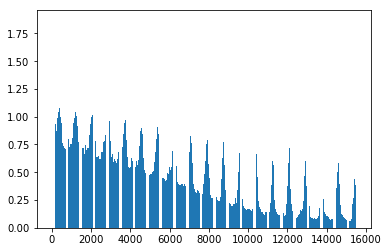

In [21]:
plt.show()

In [22]:
f.close()